Created payload-only noise model:
  - Payload qubits: [0, 1, 2, 3] (noisy)
  - Check qubits: [4, 5, 6, 7, 8, 9, 10, 11] (noiseless)
  - Single-qubit error rate: 0.4
  - Two-qubit error rate: 0.0
NoiseModel:
  Basis gates: ['cx', 'h', 'id', 'rx', 'ry', 'rz', 'sx', 'u1', 'u2', 'u3', 'x']
  Instructions with noise: ['sx', 'u3', 'x', 'u1', 'rx', 'rz', 'u2', 'h', 'ry']
  Qubits with noise: [0, 1, 2, 3]
  Specific qubit errors: [('u1', (0,)), ('u1', (1,)), ('u1', (2,)), ('u1', (3,)), ('u2', (0,)), ('u2', (1,)), ('u2', (2,)), ('u2', (3,)), ('u3', (0,)), ('u3', (1,)), ('u3', (2,)), ('u3', (3,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('rx', (0,)), ('rx', (1,)), ('rx', (2,)), ('rx', (3,)), ('rz', (0,)), ('rz', (1,)), ('rz', (2,)), ('rz', (3,)), ('ry', (0,)), ('ry', (1,)), ('ry', (2,)), ('ry', (3,)), ('h', (0,)), ('h', (1,)), ('h', (2,)), ('h', (3,))]
node.name: h
node.name: h
node.name: h
node.name: h
node.name: h
node.name: h

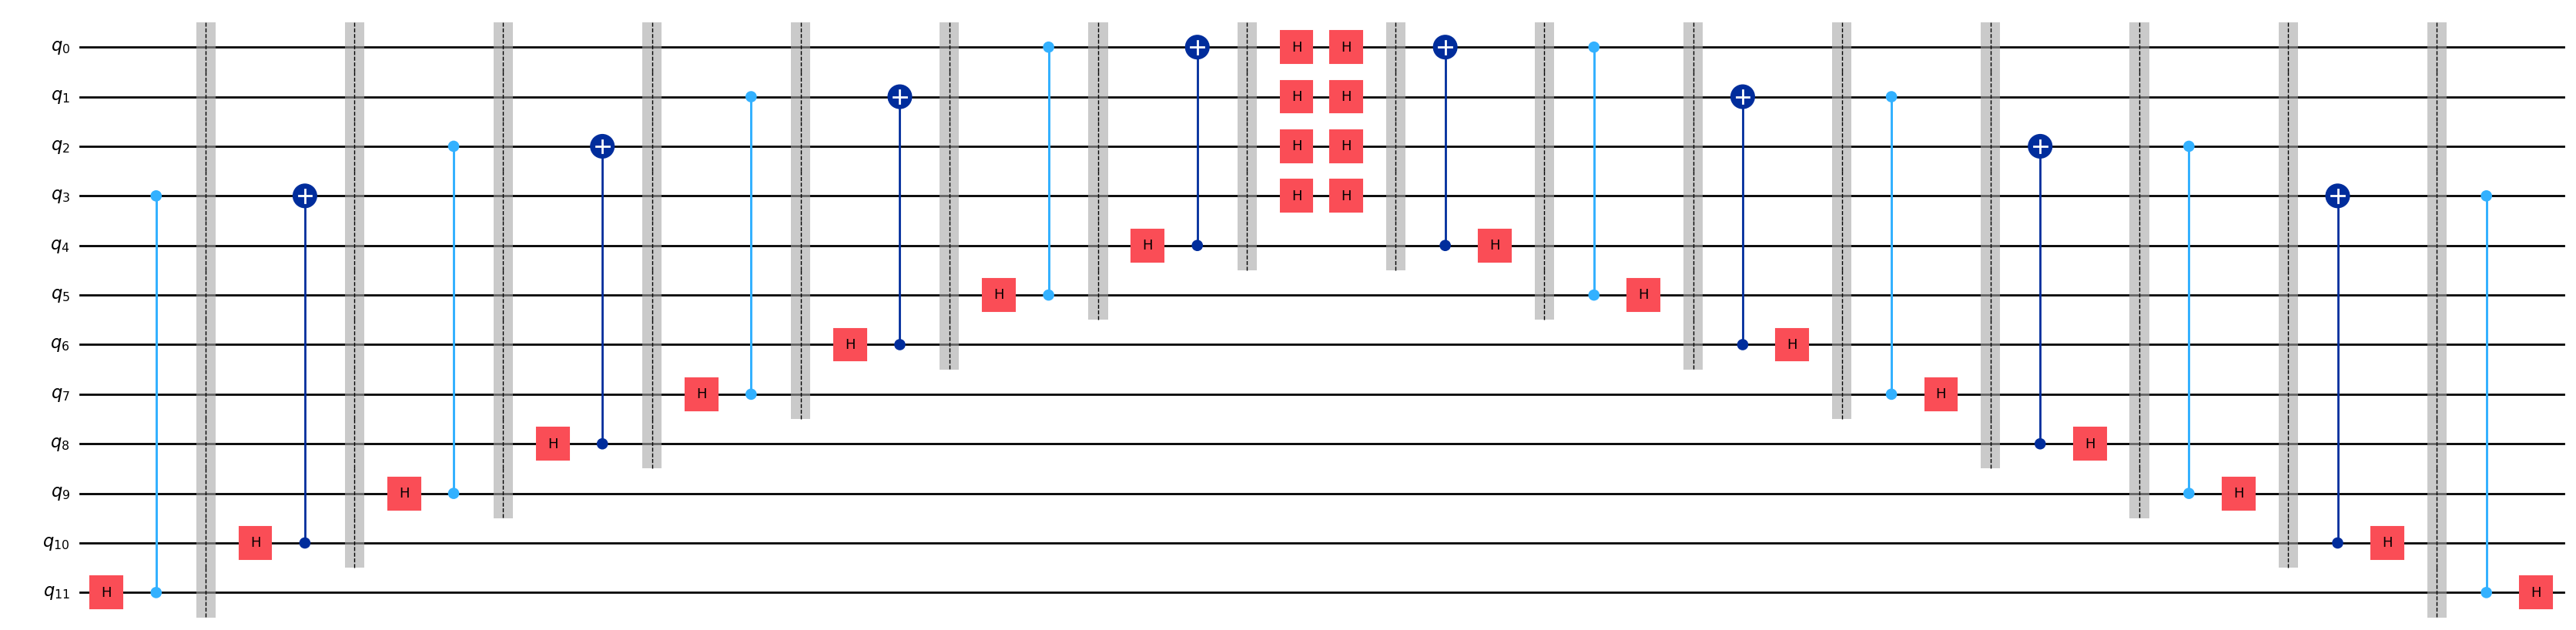

Raw counts: {'110111011010': 2, '100111011010': 6, '111011101111': 4, '111010101111': 5, '101110111111': 7, '011001110101': 4, '100101101001': 2, '010101100001': 14, '011010100111': 7, '110100101001': 19, '111001101101': 8, '011111100111': 6, '111111101111': 3, '011110100111': 3, '101011011110': 7, '011010000110': 18, '111010111111': 9, '101010101111': 5, '110110001010': 19, '001101010100': 19, '000110100011': 17, '100011101011': 25, '111101011100': 6, '011101100101': 3, '100110011010': 10, '101001111101': 7, '101001001100': 24, '001011110111': 17, '111100011100': 20, '010111110011': 8, '101000111101': 17, '011101000100': 21, '110101111001': 5, '111111011110': 3, '110111001010': 27, '111001011100': 11, '011010010110': 7, '111101101101': 4, '010011100011': 19, '011100110101': 25, '111101111101': 8, '000110010010': 15, '111100111101': 21, '101011111111': 5, '001010110111': 21, '011101010100': 6, '100001011000': 25, '100011001010': 72, '111011111111': 7, '010110010010': 9, '111011001110':

In [2]:
#!/usr/bin/env python3
"""
Simple pytest for QAOA Z-check protection verification.

Starting with one test at a time to verify Z checks provide fidelity ≈ 1.
"""

import numpy as np
import pytest
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
import networkx as nx

from utils.pce_vs_zne_utils import (
    get_ideal_expectation,
    apply_measurement_basis,
    compute_expectation_value,
    filter_counts
)
from utils.noise_models import create_payload_only_noise_model
from utils.pauli_checks import convert_to_PCS_circ


def test_z_check_perfect_protection():
    """
    Test that Z checks on every qubit yield fidelity ≈ 1 for Z measurements.
    
    Uses isolated phase operators (RZ gates only) with payload-only noise.
    This is the core test for Z-check protection effectiveness.
    """
    # Simple setup
    num_qubits = 4
    num_checks = 8
    
    # Create simple RZ circuit (isolated phase operators)
    circuit = QuantumCircuit(num_qubits)
    
    # Add RZ rotations to each qubit
    for i in range(num_qubits):
        circuit.h(i)
        circuit.h(i)
    
    # Z observable for all qubits
    pauli_string = 'ZZZZ'
    
    # Get ideal expectation (noiseless)
    ideal_expectation = get_ideal_expectation(circuit, pauli_string)
    
    # Create payload-only noise model (checks are noiseless)
    noise_model = create_payload_only_noise_model(
        num_payload_qubits=num_qubits,
        num_check_qubits=num_checks,
        prob_1_qubit=0.4,
        prob_2_qubit=0.0
    )
    backend = AerSimulator(noise_model=noise_model)
    
    # Apply Z checks to protect the circuit
    signs, pcs_circuit = convert_to_PCS_circ(
        circuit, 
        num_qubits=num_qubits, 
        num_checks=num_checks,
        only_Z_checks=False,
        barriers=True
    )

    display(pcs_circuit.draw("mpl", fold=-1))
    
    # Execute WITHOUT transpilation to preserve gate structure
    measurement_circuit = pcs_circuit.copy()
    apply_measurement_basis(measurement_circuit, pauli_string)
    measurement_circuit.measure_all()
    
    # Run directly on simulator (skip transpilation)
    job = backend.run(measurement_circuit, shots=10000)
    results = job.result()
    counts = results.get_counts()
    
    print("Raw counts:", counts)
    
    # Filter counts based on check data
    total_qubits = pcs_circuit.num_qubits
    num_checks = total_qubits - num_qubits
    filtered_counts = filter_counts(num_checks, signs, counts)
    
    print("Filtered counts:", filtered_counts)
    print(f"Post-selection rate: {sum(filtered_counts.values()) / sum(counts.values()):.3f}")
    
    # Compute expectation value
    measured_expectation = compute_expectation_value(filtered_counts, pauli_string)
    
    # Calculate fidelity
    fidelity = abs(measured_expectation / ideal_expectation)
    
    # Print results for debugging
    print(f"\n=== Z-CHECK PROTECTION TEST ===")
    print(f"Ideal expectation: {ideal_expectation}")
    print(f"Measured expectation: {measured_expectation}")
    print(f"Fidelity: {fidelity}")
    print(f"Error: {abs(measured_expectation - ideal_expectation)}")
    print(f"Signs: {signs}")
    print("=" * 40)
    
    # Z checks should provide near-perfect protection for Z measurements
    assert fidelity > 0.95, f"Z-check protection failed: fidelity = {fidelity}"
    
    print("✅ Z-check protection test PASSED!")

test_z_check_perfect_protection()